In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import json

In [2]:
flights = pd.read_csv("round2_training/round2/round2_training1.csv")

In [3]:
flights.head()

,id,timeAtServer,aircraft,latitude,longitude,baroAltitude,geoAltitude,numMeasurements,measurements
0,1,0.000,109,51.606740,-0.204849,2590.80,2590.80,5,"[[532,969020406,89],[216,969100125,23],[169,39..."
1,2,0.000,840,51.280781,-0.698624,8907.78,8846.82,9,"[[532,976779968,72],[185,268603093,64],[207,23..."
2,3,0.000,1819,51.354567,-0.304184,5791.20,5722.62,8,"[[532,980862171,91],[294,980898968,101],[169,3..."
3,4,0.001,794,36.926864,-9.295270,11582.40,11658.60,2,"[[136,927757328,52],[163,74974406666.6667,19]]"
4,5,0.001,719,46.953053,14.289973,10972.80,10820.40,6,"[[149,957322046,48],[143,957512484,102],[133,9..."


### Measurements distribution

In [3]:
meas_stats = pd.DataFrame(flights.numMeasurements.describe(percentiles=[0.5, 0.75, 0.9, 0.95]).round())
meas_stats

,numMeasurements
count,6535444.0
mean,4.0
std,3.0
min,2.0
50%,3.0
75%,6.0
90%,8.0
95%,10.0
max,30.0


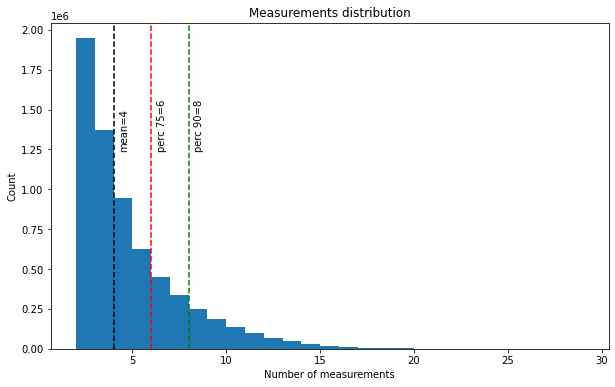

In [4]:
plt.figure(figsize=(10,6))
plt.hist(flights.numMeasurements, bins=range(2, 30))

mean = int(meas_stats.loc['mean'])
plt.axvline(mean, linestyle='--', c='k')
plt.text(mean+0.3, 1.25e6, 'mean={}'.format(mean), rotation=90)

p75 = int(meas_stats.loc['75%'])
plt.axvline(p75, linestyle='--', c='r')
plt.text(p75+0.3, 1.25e6, 'perc 75={}'.format(p75), rotation=90)

p90 = int(meas_stats.loc['90%'])
plt.axvline(p90, linestyle='--', c='g')
plt.text(p90+0.3, 1.25e6, 'perc 90={}'.format(p90), rotation=90)

plt.xlabel('Number of measurements')
plt.ylabel('Count')
plt.title('Measurements distribution')
plt.show()

### Visualize an example flight

In [5]:
# Find some flights over England
flights.loc[flights.latitude.between(50, 57) & flights.longitude.between(-2, 2)].head(10)

,id,timeAtServer,aircraft,latitude,longitude,baroAltitude,geoAltitude,numMeasurements,measurements
0,1,0.000,109,51.606740,-0.204849,2590.80,2590.80,5,"[[532,969020406,89],[216,969100125,23],[169,39..."
1,2,0.000,840,51.280781,-0.698624,8907.78,8846.82,9,"[[532,976779968,72],[185,268603093,64],[207,23..."
2,3,0.000,1819,51.354567,-0.304184,5791.20,5722.62,8,"[[532,980862171,91],[294,980898968,101],[169,3..."
13,14,0.003,2041,54.971786,-0.496647,11277.60,11170.92,5,"[[184,4328242833.33333,20],[695,19964177833.33..."
15,16,0.003,1143,51.708206,1.012004,5090.16,5036.82,5,"[[455,15742152000,40],[583,-1230441000,14],[35..."
61,62,0.016,2417,51.322037,-1.859510,10668.00,10523.22,11,"[[185,279306140,108],[466,58027029250,92],[207..."
100,101,0.029,530,55.087646,-1.923981,8633.46,8618.22,3,"[[658,5878005000,122],[173,47227934083.3333,17..."
107,108,0.030,2676,51.966775,-1.447135,8839.20,8778.24,3,"[[207,23876496250,153],[521,81620067916.6667,1..."
108,109,0.030,1419,51.573990,1.027073,7376.16,7338.06,7,"[[207,23879446000,176],[327,968632406,96],[304..."
143,144,0.042,181,51.087204,-0.031846,1584.96,1524.00,2,"[[169,39359471416.6667,39],[700,66359167250,11]]"


In [6]:
air181 = flights.loc[flights.aircraft == 181].copy()

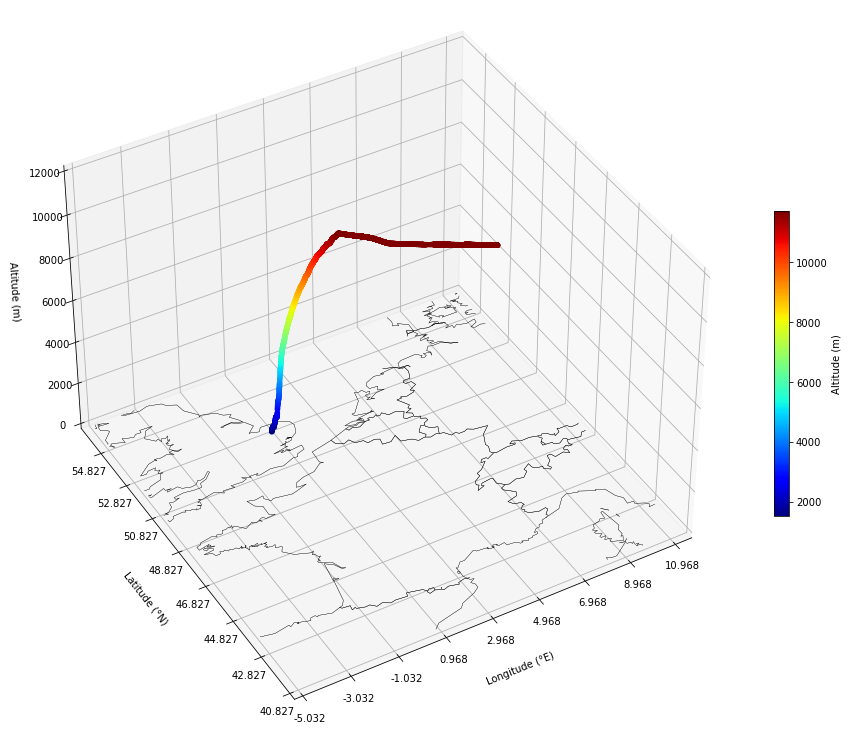

In [7]:
lat = air181.latitude.values
long = air181.longitude.values
geoAltitude = air181.geoAltitude.values

# Create a figure with 3d projection
fig = plt.figure(figsize=(16,14))
ax = fig.gca(projection='3d')

# Define lower left, uperright lattitude and longitude respectively
ll_lat, up_lat, ll_long, up_long = min(lat)-5, max(lat)+5, min(long)-5, max(long)+5

# Create a Basemap instance
bm = Basemap(llcrnrlon=ll_long, llcrnrlat=ll_lat,
             urcrnrlon=up_long, urcrnrlat=up_lat,
             epsg=4326, resolution='l',
             fix_aspect=False, ax=ax) 

# Add Basemap to the figure
ax.add_collection3d(bm.drawcoastlines(linewidth=0.25))
ax.add_collection3d(bm.drawcountries(linewidth=0.35))
ax.view_init(azim=240, elev=40)
ax.set_xlabel('Longitude (°E)', labelpad=15)
ax.set_ylabel('Latitude (°N)', labelpad=15)
ax.set_zlabel('Altitude (m)', labelpad=15)

# Add meridian and parallel gridlines
meridians = np.arange(ll_long, up_long, 2)
parallels = np.arange(ll_lat, up_lat, 2)
ax.set_yticks(parallels)
ax.set_yticklabels(np.round(parallels, 3))
ax.set_xticks(meridians)
ax.set_xticklabels(np.round(meridians, 3))
ax.set_zlim(0, 12000)

plot = ax.scatter3D(long, lat, geoAltitude, c=geoAltitude, cmap="jet")
fig.colorbar(plot, label='Altitude (m)', shrink=0.4)

plt.show()

### Timestamp measurements

In [8]:
# Extract the measurement data from the JSON array
# [serial number of the sensor, timestamp of the arrival at the receiver (in nanoseconds), strength indicator (RSSI)]
air181.measurements = air181.measurements.apply(lambda row: json.loads(row))

Now we will explode the measurements column so that the sensor, timestamp and RSSI information of each measurement will be presnted as a separate column.

In [9]:
air181_exp = pd.concat([air181, air181.measurements.apply(pd.Series)], axis=1)

In [10]:
for col in range(max(air181.numMeasurements)):
    meas_columns = air181_exp[col].apply(pd.Series)
    
    col_names = {0: "{}_sensor".format(col),
                 1: "{}_tmp".format(col),
                 2: "{}_rssi".format(col)}
    
    meas_columns.rename(mapper=col_names, axis=1, inplace=True)
    air181_exp = pd.concat([air181_exp, meas_columns], axis=1)
    air181_exp.drop(columns=col, inplace=True)

In [11]:
air181_exp.head()

,id,timeAtServer,aircraft,latitude,longitude,baroAltitude,geoAltitude,numMeasurements,measurements,0_sensor,...,7_rssi,8_sensor,8_tmp,8_rssi,9_sensor,9_tmp,9_rssi,10_sensor,10_tmp,10_rssi
143,144,0.042,181,51.087204,-0.031846,1584.96,1524.00,2,"[[169, 39359471416.6667, 39], [700, 6635916725...",169.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1884,1885,1.016,181,51.086243,-0.031326,1592.58,1531.62,4,"[[399, 15390701166.6667, 55], [169, 4033950525...",399.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2671,2672,1.462,181,51.085727,-0.031052,1592.58,1524.00,2,"[[169, 40809516916.6667, 29], [700, 6780920916...",169.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4724,4725,2.610,181,51.084366,-0.030212,1600.20,1531.62,3,"[[169, 41914476083.3333, 38], [700, 6891416550...",169.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5479,5480,3.044,181,51.083771,-0.030064,1607.82,1546.86,4,"[[169, 42369493666.6667, 44], [700, 6936918208...",169.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


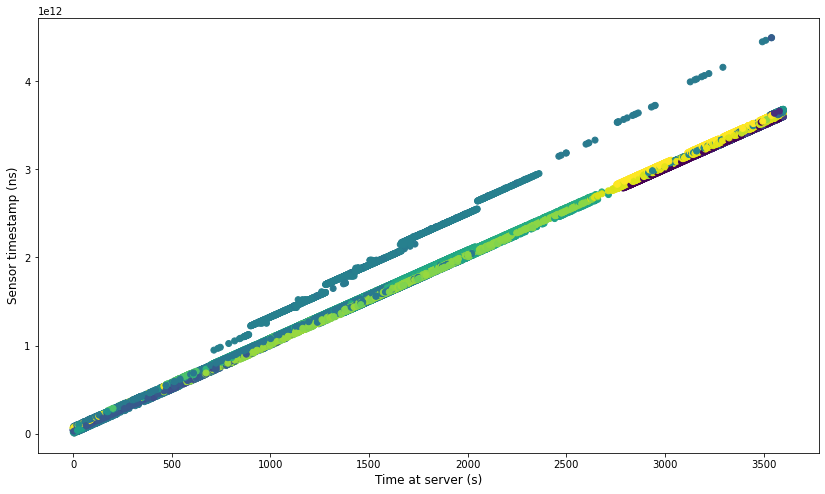

In [12]:
fig, ax = plt.subplots(figsize=(14, 8))

for sensor in range(max(air181.numMeasurements)):
    scatter = ax.scatter(air181_exp.timeAtServer, air181_exp['{}_tmp'.format(sensor)], 
               c=air181_exp['{}_sensor'.format(sensor)])

ax.set_xlabel('Time at server (s)', size=12)
ax.set_ylabel('Sensor timestamp (ns)', size=12)

plt.show()

Calculation of the timestamp differences between the sensors. 

In [13]:
meas_values = air181_exp.loc[:, ['{}_tmp'.format(sensor) for sensor in range(max(air181.numMeasurements))]].values

In [14]:
tmp_columns = ['{}_tmp'.format(sensor) for sensor in range(max(air181.numMeasurements))]

for col in range(1, max(air181.numMeasurements)):
    for col2 in range(col):
        air181_exp['diff_{}_{}'.format(col, col2)] = np.NaN

for i, row in air181_exp.iterrows():
    tmp_values = row[tmp_columns]
    
    for col in range(1, max(air181.numMeasurements)):
        for col2 in range(col):
            air181_exp.loc[i, 'diff_{}_{}'.format(col, col2)] = tmp_values[col] - tmp_values[col2]


In [15]:
air181_exp.head()

,id,timeAtServer,aircraft,latitude,longitude,baroAltitude,geoAltitude,numMeasurements,measurements,0_sensor,...,diff_10_0,diff_10_1,diff_10_2,diff_10_3,diff_10_4,diff_10_5,diff_10_6,diff_10_7,diff_10_8,diff_10_9
143,144,0.042,181,51.087204,-0.031846,1584.96,1524.00,2,"[[169, 39359471416.6667, 39], [700, 6635916725...",169.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1884,1885,1.016,181,51.086243,-0.031326,1592.58,1531.62,4,"[[399, 15390701166.6667, 55], [169, 4033950525...",399.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2671,2672,1.462,181,51.085727,-0.031052,1592.58,1524.00,2,"[[169, 40809516916.6667, 29], [700, 6780920916...",169.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4724,4725,2.610,181,51.084366,-0.030212,1600.20,1531.62,3,"[[169, 41914476083.3333, 38], [700, 6891416550...",169.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5479,5480,3.044,181,51.083771,-0.030064,1607.82,1546.86,4,"[[169, 42369493666.6667, 44], [700, 6936918208...",169.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


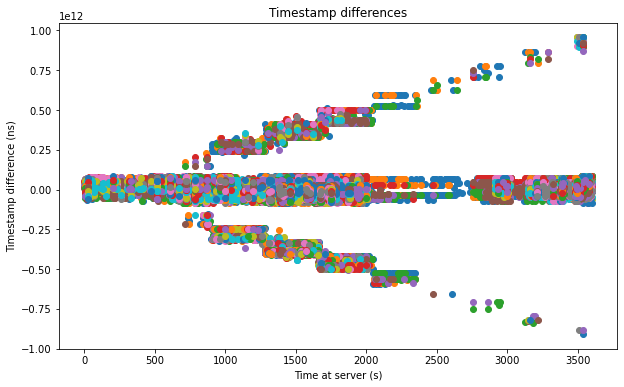

In [16]:
columns_list = [col for col in air181_exp.columns if 'diff' in col]

plt.figure(figsize=(10, 6))

for col in columns_list:
    plt.scatter(air181_exp.timeAtServer, air181_exp[col])
    
plt.xlabel('Time at server (s)')
plt.ylabel('Timestamp difference (ns)')
plt.title('Timestamp differences')

plt.show()

Plot timestamp differences for a chosen pair of sensors

In [17]:
sensor_numbers = [207, 425]
find_col = 'diff'

In [18]:
def find_sensor_values(df, sensor_numbers, find_col):
    
    if isinstance(sensor_numbers, int):
        sensor_numbers = [sensor_numbers]

    sensor_columns = [col for col in df.columns if 'sensor' in col]

    sensors_idx = []
    sensors_cols = []
    sensor_values = []

    filtered_sensors = df[sensor_columns].isin(sensor_numbers)
    filtered_sensors = filtered_sensors.loc[filtered_sensors.sum(axis=1) >=len(sensor_numbers)]

    for i, row in filtered_sensors.iterrows():
        cols = list(row.loc[row == True].index)
        cols = [col.strip('_sensor') for col in cols]
        if find_col == 'diff':
            cols = find_col + '_' + cols[1] + '_' + cols[0] 
        else:
            assert len(sensor_numbers) == 1, 'You may be looking for a single sensor reading at a time'
            
            cols = cols[0] + '_' + find_col

        sensors_idx.append(i)
        sensors_cols.append(cols)

    for i, idx in enumerate(sensors_idx):
        sensor_values.append(df.loc[idx, sensors_cols[i]])
        
    return sensor_values, sensors_idx

In [19]:
values_to_plot, sensors_idx = find_sensor_values(air181_exp, sensor_numbers, find_col)

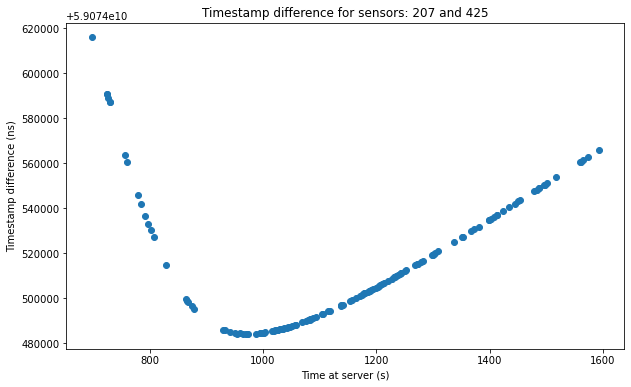

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(air181_exp.loc[sensors_idx, 'timeAtServer'], np.abs(values_to_plot))
plt.xlabel('Time at server (s)')
plt.ylabel('Timestamp difference (ns)')
plt.title('Timestamp difference for sensors: {} and {}'.format(sensor_numbers[0], sensor_numbers[1]))

plt.show()

Now we will calculate and plot the distance differences.

In [21]:
dist_diff = air181_exp.loc[sensors_idx, ['timeAtServer', 'latitude', 'longitude', 'geoAltitude']]

In [22]:
dist_diff.head()

,timeAtServer,latitude,longitude,geoAltitude
1258065,697.317,50.101939,0.413398,8054.34
1307454,724.586,50.064056,0.462221,8282.94
1307455,724.586,50.064056,0.462221,8275.32
1311106,726.593,50.061127,0.465907,8290.56
1314762,728.622,50.058197,0.469449,8313.42


In [3]:
sensor_data = pd.read_csv("round2_training/round2/round2_sensors.csv")

In [24]:
# Convert WSG84 coordinates to cartesian ones

def lla_to_ecef(latitude, longitude, altitude):
    
    latitude = np.radians(latitude)
    longitude = np.radians(longitude)

    # WSG84 ellipsoid constants
    a = 6378137
    e = 8.1819190842622e-2

    # Prime vertical radius of curvature
    N = a / np.sqrt(1 - e**2 * np.sin(latitude)**2)

    x = (N + altitude) * np.cos(latitude) * np.cos(longitude)
    y = (N + altitude) * np.cos(latitude) * np.sin(longitude)
    z = ((1 - e**2) * N + altitude) * np.sin(latitude)
    
    return x, y, z

In [25]:
def calculateDist(row, sensor):
    x1, y1, z1 = row.latitude, row.longitude, row.geoAltitude
    x2, y2, z2 = sensor_data.loc[sensor-1, ['latitude', 'longitude', 'height']] 
    
    x1, y1, z1 = lla_to_ecef(x1, y1, z1)
    x2, y2, z2 = lla_to_ecef(x2, y2, z2)
    
    return np.sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2) / 1000

In [26]:
for sensor in sensor_numbers:
    dist_diff['sensor{}_dist'.format(sensor)] = dist_diff.apply(calculateDist, args=(sensor,), axis=1)

In [27]:
dist_diff.head(10)

,timeAtServer,latitude,longitude,geoAltitude,sensor207_dist,sensor425_dist
1258065,697.317,50.101939,0.413398,8054.34,189.332676,38.700603
1307454,724.586,50.064056,0.462221,8282.94,194.634343,35.075126
1307455,724.586,50.064056,0.462221,8275.32,194.633910,35.073313
1311106,726.593,50.061127,0.465907,8290.56,195.041509,34.811543
1314762,728.622,50.058197,0.469449,8313.42,195.445219,34.552804
1314763,728.622,50.058197,0.469449,8305.80,195.444785,34.550958
1364766,756.079,50.019495,0.518733,8526.78,200.854199,31.481935
1372221,760.167,50.014002,0.526008,8572.50,201.632195,31.113940
1406887,778.930,49.987327,0.559857,8702.04,205.362067,29.501403
1417746,784.877,49.978762,0.570695,8740.14,206.559497,29.070530


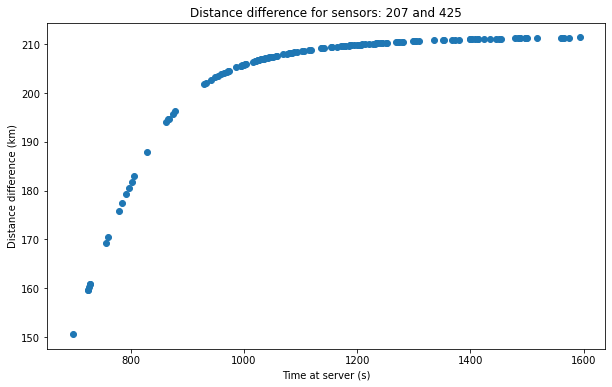

In [28]:
plt.figure(figsize=(10, 6))
plt.scatter(dist_diff.timeAtServer, dist_diff['sensor{}_dist'.format(sensor_numbers[0])] - 
            dist_diff['sensor{}_dist'.format(sensor_numbers[1])])
plt.xlabel('Time at server (s)')
plt.ylabel('Distance difference (km)')
plt.title('Distance difference for sensors: {} and {}'.format(sensor_numbers[0], sensor_numbers[1]))

plt.show()

To check whether preceding plots are correct, we will plot the flight route together with the location of the chosen sensors.

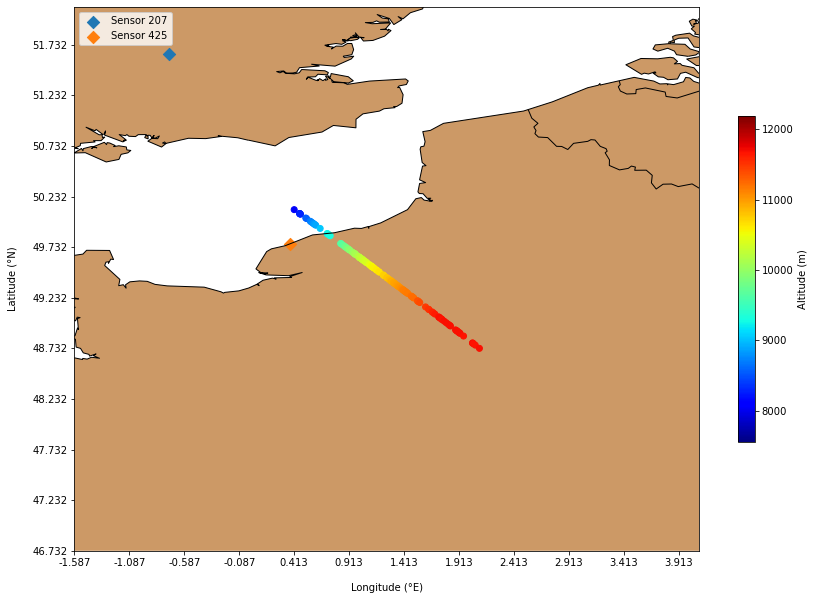

In [29]:
lat = dist_diff.latitude.values
long = dist_diff.longitude.values
geoAltitude = dist_diff.geoAltitude.values

fig, ax = plt.subplots(figsize=(14,10))

# Define lower left, uperright lattitude and longitude respectively
ll_lat, up_lat, ll_long, up_long = min(lat)-2, max(lat)+2, min(long)-2, max(long)+2

# Create a Basemap instance
# In order to use the resolutions highere than 'l' (low) you have to download and
# install those files separately with: conda install -c conda-forge basemap-data-hires
m = Basemap(llcrnrlon=ll_long, llcrnrlat=ll_lat,
             urcrnrlon=up_long, urcrnrlat=up_lat,
             epsg=4326, resolution='i',
             fix_aspect=False, ax=ax) 


s1x, s1y = sensor_data.loc[sensor_numbers[0]-1, ['latitude', 'longitude']]
s2x, s2y = sensor_data.loc[sensor_numbers[1]-1, ['latitude', 'longitude']]
                           
ax.scatter(s1y, s1x, label='Sensor {}'.format(sensor_numbers[0]), marker='D', s=75)
ax.scatter(s2y, s2x, label='Sensor {}'.format(sensor_numbers[1]), marker='D', s=75)
ax.legend()

m.drawcoastlines() # use only if coastline will be visible on the map
m.drawcountries(color='k', linewidth=1)
m.fillcontinents(color='#cc9966',lake_color='#99ffff', zorder=0)

plot = ax.scatter(long, lat, c=geoAltitude,  cmap="jet", vmin=min(geoAltitude)-500, vmax=max(geoAltitude)+500)
fig.colorbar(plot, label='Altitude (m)', shrink=0.6)

ax.set_xlabel('Longitude (°E)', labelpad=15)
ax.set_ylabel('Latitude (°N)', labelpad=15)

meridians = np.arange(ll_long, up_long, 0.5)
parallels = np.arange(ll_lat, up_lat, 0.5)
ax.set_yticks(parallels)
ax.set_yticklabels(np.round(parallels, 3))
ax.set_xticks(meridians)
ax.set_xticklabels(np.round(meridians, 3))

plt.show()

### Signal Strength measurements

For the chosen flight we are going to plot the signal strength values for all the sensors that recorded aircraft position.

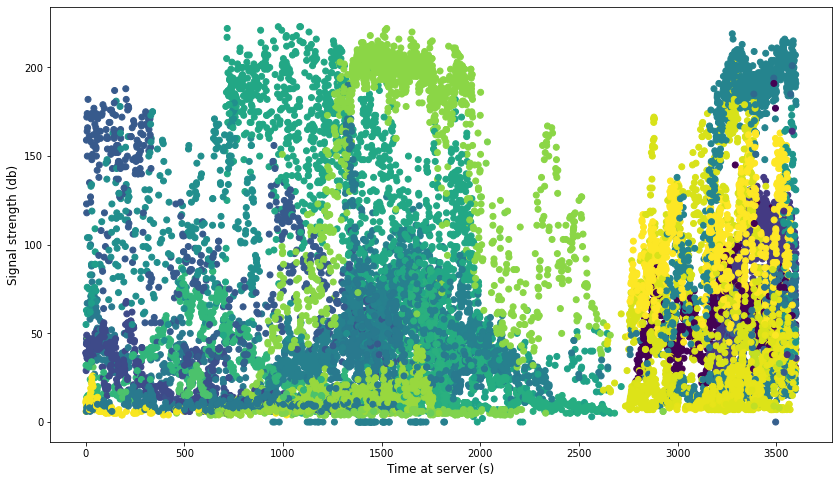

In [30]:
fig, ax = plt.subplots(figsize=(14, 8))

for sensor in range(max(air181.numMeasurements)):
    scatter = ax.scatter(air181_exp.timeAtServer, air181_exp['{}_rssi'.format(sensor)], 
               c=air181_exp['{}_sensor'.format(sensor)])

ax.set_xlabel('Time at server (s)', size=12)
ax.set_ylabel('Signal strength (db)', size=12)

plt.show()

As we can see at the preceding plot, the signal strength for a particular sensor seems to be U-shaped (parabola), which means that signal strength increases while heading towards the sensor, and conversely, it decreases while moving away from sensor's position.

Now we will depict the singal strength for a chosen sensor together with calculated distance between the aircraft and the sensor.

In [31]:
sensor_numbers = [207, 425]

# Extract sensors RSSI data
s207_rssi, s207_idx  = find_sensor_values(air181_exp, sensor_numbers[0], 'rssi')
s425_rssi, s425_idx  = find_sensor_values(air181_exp, sensor_numbers[1], 'rssi')

# Calculate the distance between a sensor and an aircraft
s207_dist = air181_exp.loc[s207_idx].apply(calculateDist, args=(sensor_numbers[0],), axis=1)
s425_dist = air181_exp.loc[s425_idx].apply(calculateDist, args=(sensor_numbers[1],), axis=1)

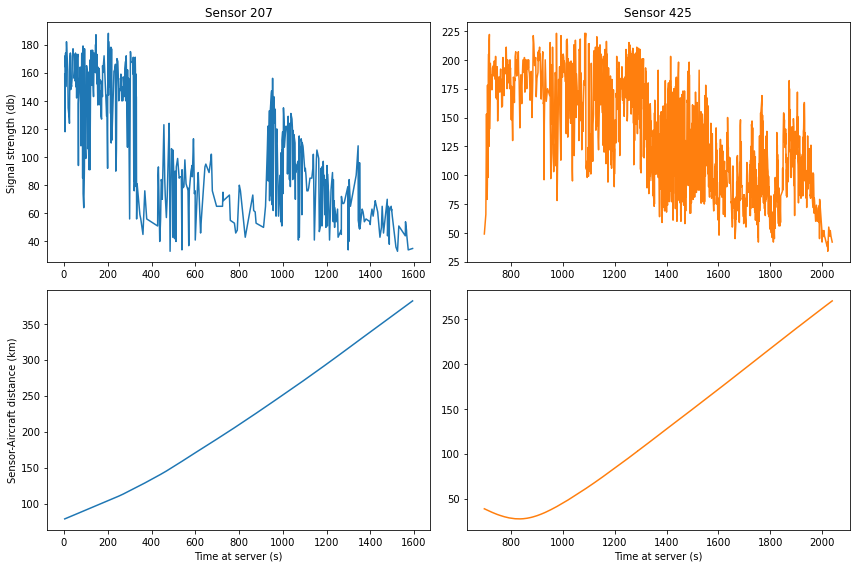

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=False)

axes[1, 0].plot(air181_exp.loc[s207_idx, 'timeAtServer'], s207_dist, 
         label='sensor {} distance'.format(sensor_numbers[0]))
axes[1, 0].set_ylabel('Sensor-Aircraft distance (km)')
axes[1, 0].set_xlabel('Time at server (s)')

axes[0, 0].plot(air181_exp.loc[s207_idx, 'timeAtServer'], s207_rssi,
         label='sensor {} RSSI'.format(sensor_numbers[0]))
axes[0, 0].set_ylabel('Signal strength (db)')
axes[0, 0].set_title('Sensor {}'.format(sensor_numbers[0]))

axes[1, 1].plot(air181_exp.loc[s425_idx, 'timeAtServer'], s425_dist, 'tab:orange',
         label='sensor {} distance'.format(sensor_numbers[1]))
axes[1, 1].set_xlabel('Time at server (s)')

axes[0, 1].plot(air181_exp.loc[s425_idx, 'timeAtServer'], s425_rssi, 'tab:orange',
         label='sensor {} RSSI'.format(sensor_numbers[1]))
axes[0, 1].set_title('Sensor {}'.format(sensor_numbers[1]))

plt.tight_layout()

We can clearly discern the negative correlation between the RSSI and the aircraft-sensor distance - as the distance between the aircraft and the sensor increases the signal strength decreases. However there is a lot of noise, thus this variable has not much predictive abilities.

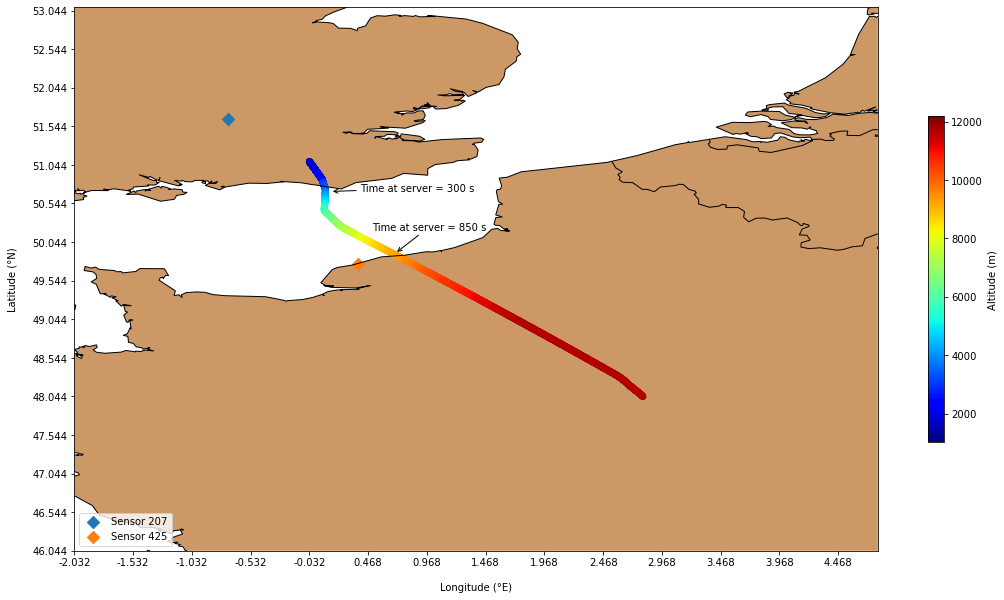

In [33]:
lat = air181_exp.loc[air181_exp.timeAtServer.between(0, 2000), 'latitude'].values
long = air181_exp.loc[air181_exp.timeAtServer.between(0, 2000), 'longitude'].values
geoAltitude = air181_exp.loc[air181_exp.timeAtServer.between(0, 2000), 'geoAltitude'].values

fig, ax = plt.subplots(figsize=(18,10))

# Define lower left, uperright lattitude and longitude respectively
ll_lat, up_lat, ll_long, up_long = min(lat)-2, max(lat)+2, min(long)-2, max(long)+2

# Create a Basemap instance
# In order to use the resolutions highere than 'l' (low) you have to download and
# install those files separately with: conda install -c conda-forge basemap-data-hires
m = Basemap(llcrnrlon=ll_long, llcrnrlat=ll_lat,
             urcrnrlon=up_long, urcrnrlat=up_lat,
             epsg=4326, resolution='i',
             fix_aspect=False, ax=ax) 


s1x, s1y = sensor_data.loc[sensor_numbers[0]-1, ['latitude', 'longitude']]
s2x, s2y = sensor_data.loc[sensor_numbers[1]-1, ['latitude', 'longitude']]
                           
ax.scatter(s1y, s1x, label='Sensor {}'.format(sensor_numbers[0]), marker='D', s=75)
ax.scatter(s2y, s2x, label='Sensor {}'.format(sensor_numbers[1]), marker='D', s=75)
ax.legend()

m.drawcoastlines() # use only if coastline will be visible on the map
m.drawcountries(color='k', linewidth=1)
m.fillcontinents(color='#cc9966',lake_color='#99ffff', zorder=0)

plot = ax.scatter(long, lat, c=geoAltitude,  cmap="jet", vmin=min(geoAltitude)-500, vmax=max(geoAltitude)+500)
fig.colorbar(plot, label='Altitude (m)', shrink=0.6)

ax.set_xlabel('Longitude (°E)', labelpad=15)
ax.set_ylabel('Latitude (°N)', labelpad=15)

meridians = np.arange(ll_long, up_long, 0.5)
parallels = np.arange(ll_lat, up_lat, 0.5)
ax.set_yticks(parallels)
ax.set_yticklabels(np.round(parallels, 3))
ax.set_xticks(meridians)
ax.set_xticklabels(np.round(meridians, 3))

x1, y1 = m(0.4, 50.7)
ax.annotate('Time at server = 300 s', xy=(0.15, 50.7), xycoords='data', xytext=(x1, y1), 
            textcoords='data', arrowprops={'arrowstyle': '->'})

x2, y2 = m(0.5, 50.2)
ax.annotate('Time at server = 850 s', xy=(0.7, 49.9), xycoords='data', xytext=(x2, y2),
            textcoords='data', arrowprops={'arrowstyle': '->'})

plt.show()

The signal strength plots in conjunction with the map show that at the time when the plane flies above the English Channel, the RSSI significantly decreases, this phenomena has been reported by sensor 207 at the time from 300 s to 850 s (time at server).

To evaluate the loss of the signal strength above the water surafce, we will fit the regression model into the RSSI data, but only on the parts of the route where the plane flies above the land. This model will be used to predict the signal strength value for the corresponding distance from the sensor, assuming that the loss is constant irrespective of the surface above which the aircraft flies. Each deviation of the real RSSI from the predicted value indicates on the additional influence of the water surface on the signal loss.

In [34]:
# Determine whether given coordinate point is in land
in_land = air181_exp.apply(lambda x: m.is_land(x.longitude, x.latitude), axis=1)
in_land = in_land.loc[s207_idx]
in_land = in_land.loc[in_land == True]

In [35]:
# Filter RSSI values
s207_rssi_land = []
s207_dist_land = []
s207_rssi_water = []
s207_dist_water = []

for rssi, dist, idx in list(zip(s207_rssi, s207_dist, s207_idx)):
    if idx in list(in_land.index):
        s207_rssi_land.append(rssi)
        s207_dist_land.append(dist)
    else:
        s207_rssi_water.append(rssi)
        s207_dist_water.append(dist)

Now we will fit the linear regression model into the data.

In [37]:
from sklearn.linear_model import LinearRegression

s207_dist_land = np.array(s207_dist_land).reshape(-1, 1)
reg = LinearRegression().fit(s207_dist_land, s207_rssi_land)

print('Coefficient of determination R^2: ', reg.score(s207_dist_land, s207_rssi_land))

Coefficient of determination R^2:  0.7063388307405261


In [38]:
coeff = reg.coef_
intercept = reg.intercept_

# Predict the RSSI for the distances that correspond to the flight above water
s207_dist_water = np.array(s207_dist_water).reshape(-1, 1)
pred_rssi_water = np.array(reg.predict(s207_dist_water)).reshape(-1, 1)

print('Coefficient of determination R^2 (water): ', reg.score(s207_dist_water, s207_rssi_water))
print('Mean square error: ', np.mean((pred_rssi_water - s207_rssi_water)**2))

Coefficient of determination R^2 (water):  -0.5702870519096526
Mean square error:  2873.961148967548


The negative value of the coefficient of determination implies that the regression model that was fitted into the 'land' RSSI data doesn't describe at all the relationship between distance and RSSI for the 'water' flight-route. This happend due to an order of magnitude greater loss of signal strength when transmitting over the water's surface. Thus it is necessary to distinguish between those two types of surfaces and model them separately.

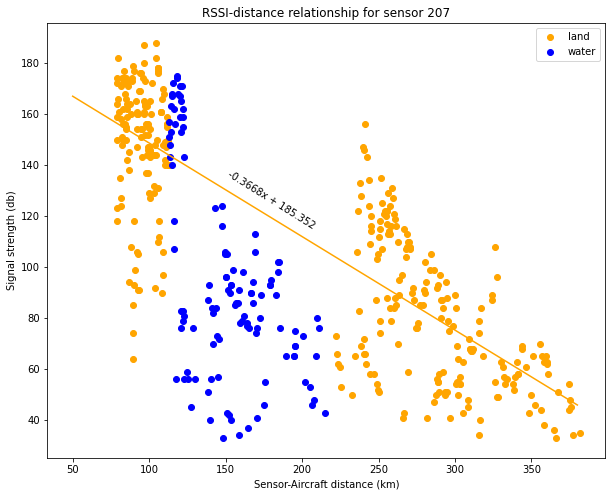

In [40]:
plt.figure(figsize=(10, 8))

plt.scatter(s207_dist_land, s207_rssi_land, label='land', color='orange')
plt.scatter(s207_dist_water, s207_rssi_water, label='water', color='b')
plt.xlabel('Sensor-Aircraft distance (km)')
plt.ylabel('Signal strength (db)')
plt.legend()
plt.title('RSSI-distance relationship for sensor 207')

x1, x2 = 50, 380
y1, y2 = x1 * coeff + intercept, x2 * coeff + intercept
 
plt.plot([x1, x2], [y1, y2], 'orange')
plt.text(150, 115, '-0.3668x + 185.352', rotation=-32)

plt.show()

### BaroAltitude and GeoAltitude

In [31]:
altitude_diff = flights.geoAltitude - flights.baroAltitude 

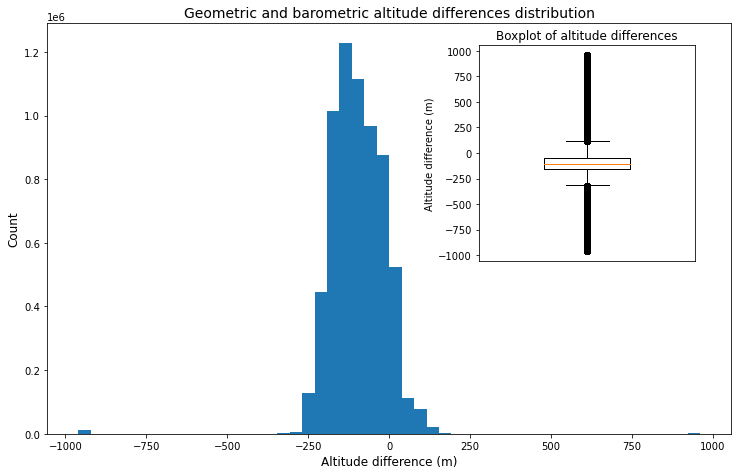

In [32]:
fig = plt.figure(figsize=(10,6))

ax1 = fig.add_axes([0, 0, 0.95, 0.95]) # window coord: (left, bottom, width, height)(in %)
ax1.hist(altitude_diff, bins=50)
ax1.set_title('Geometric and barometric altitude differences distribution', size=14)
ax1.set_xlabel('Altitude difference (m)', size=12)
ax1.set_ylabel('Count', size=12)

ax2 = fig.add_axes([0.6, 0.4, 0.3, 0.5]) # window coord: (left, bottom, width, height)(in %)
ax2.boxplot(altitude_diff, widths=0.4)
ax2.set_title('Boxplot of altitude differences')
ax2.set_ylabel('Altitude difference (m)')
ax2.set_xticks([0])

plt.show()

In [33]:
pd.DataFrame(altitude_diff.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).round())

,0
count,6535444.0
mean,-99.0
std,85.0
min,-960.0
5%,-213.0
25%,-152.0
50%,-107.0
75%,-46.0
95%,23.0
max,960.0


Below we will check whether the altitude difference is dependent on the aircraft localization.

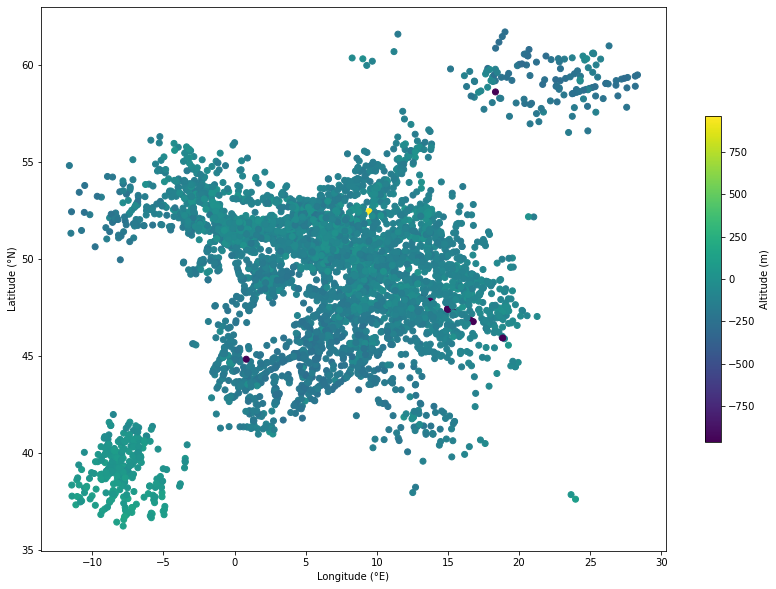

In [378]:
fig = plt.figure(figsize=(14,10))

# Select a random sample of indices
rand_idx = np.random.randint(min(flights.index), max(flights.index), size=5000)

plot = plt.scatter(flights.loc[rand_idx, 'longitude'], flights.loc[rand_idx, 'latitude'],
                   c=altitude_diff.loc[rand_idx])
plt.xlabel('Longitude (°E)')
plt.ylabel('Latitude (°N)')

fig.colorbar(plot, label='Altitude (m)', shrink=0.6)

plt.show()

It is time to calculate the mean altitude difference for each aircraft, so that we will be able to identify the planes that most frequently report the inconsistent geometric and barometric altittudes.

In [34]:
altitude_diff = pd.concat([flights.aircraft, altitude_diff], axis=1)
altitude_diff.rename({0: 'altitude_diff'}, axis=1, inplace=True)

In [35]:
altitude_diff.head()

,aircraft,altitude_diff
0,109,0.00
1,840,-60.96
2,1819,-68.58
3,794,76.20
4,719,-152.40


In [36]:
maen_altitude_diff = altitude_diff.groupby('aircraft').altitude_diff.mean()

Now we will pick out aircrafts which mean altitude difference falls below the 5th and above the 95th percentile.

In [37]:
maen_altitude_diff.loc[~maen_altitude_diff.between(-250, 50)]

aircraft
35       59.230307
37       92.785123
40      182.880000
73       53.269444
134      53.340000
           ...    
2833     55.880000
2850    135.401538
2853     70.281800
2881     61.936007
2887     77.154010
Name: altitude_diff, Length: 142, dtype: float64

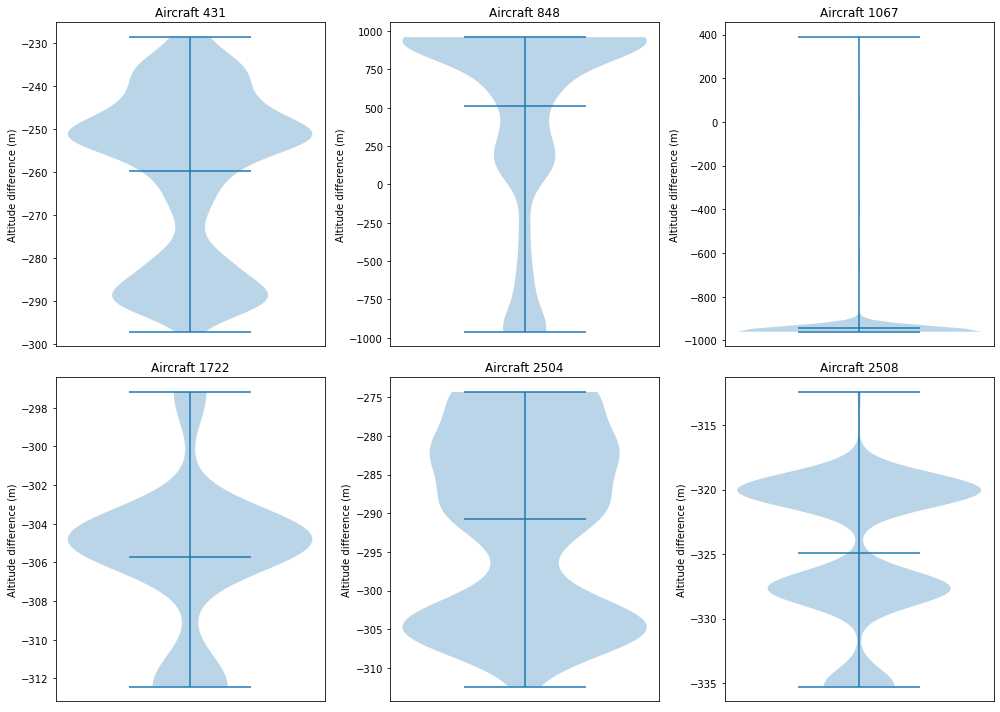

In [38]:
aircrafts = [431, 848, 1067, 1722, 2504, 2508]

fig, axes = plt.subplots(2, 3, figsize=(14,10), sharex=False)
count = 0

# Iterate through rows and columns
for row in range(2):
    for col in range(3):
        axes[row, col].violinplot(altitude_diff.loc[altitude_diff.aircraft == aircrafts[count], 'altitude_diff'],
                                  widths=0.7, showmeans=True)

        axes[row, col].set_title('Aircraft {}'.format(aircrafts[count]))
        axes[row, col].set_ylabel('Altitude difference (m)')

        axes[row, col].set_xticks([0])

        count += 1
        
plt.tight_layout()